# Visualize sample methylation matrix with PCA

This notebook is for visualizing methylation matrices and their deconvolution results

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!conda info | grep 'active env'

     active environment : 2023_06_26_SRT_deconvolution_MS
    active env location : /home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS


In [2]:
def create_pc_dict(num):
    return {i: f"PC{i+1}" for i in range(num)}

def difference(listA, listB):
    return list(set(listA).difference(set(listB)))

## Data preprocessing

In [3]:
# load data
# 1648 regions for each 127 samples = 209296 rows
data = pd.read_csv('../output/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz',sep='\t')
sample_df = pd.read_csv('../stage/metadata/samples_wgbs.20230329.tsv',sep='\t')
metadata = sample_df[['sample_id','sample_group', 'age']] \
    .rename({'sample_id':'SAMPLE_ID'},axis=1) \
    .drop_duplicates()

# blueprint cell type x immune regions reference matrix
refmat = pd.read_csv('../output/deconv_inhouse_v2.atlas.tsv.gz',sep='\t')

# merge donor sex into metadata
blueprint_df = pd.read_csv('../stage/metadata/20160816.data.index.tsv',sep='\t')\
                    .drop_duplicates('SAMPLE_ID')
metadata = pd.merge(metadata, blueprint_df[['SAMPLE_ID','DONOR_SEX']], on ='SAMPLE_ID') \
    .rename({'DONOR_SEX':'sex'},axis=1)

In [4]:
# 23 samples are in the blueprint metadata, but not in sample_df metadata.
A = data.sample_id.unique()
B = list(sample_df.sample_id)
diff_id_list = difference(A, B)

# 23 in sample_df missing metadata
# print(len(diff_id_list))

In [5]:
'''
Should expect 127 samples total if True.
Should expect 104 samples total if False.

23 samples are in the blueprint metadata, but not in 
sample_df metadata. I use the CELL_TYPE feature in the 
blueprint data to get cell type info (instead of sample_group).
This seems to be more detailed than sample_group.
'''
INCLUDE_23 = True

if INCLUDE_23:
    filtered_blueprint_df = blueprint_df[blueprint_df['SAMPLE_ID'].isin(diff_id_list)]
    filtered_blueprint_df = filtered_blueprint_df[['SAMPLE_ID', 'CELL_TYPE', 'DONOR_AGE', 'DONOR_SEX']]\
                                .rename({'CELL_TYPE':'sample_group'}, axis=1)\
                                .rename({'DONOR_AGE':'age'}, axis=1)\
                                .rename({'DONOR_SEX':'sex'}, axis=1)
    print(filtered_blueprint_df.sample_group.unique())

    metadata = pd.concat([metadata, filtered_blueprint_df], axis=0)

metadata.shape

['hematopoietic multipotent progenitor cell'
 'CD3-negative, CD4-positive, CD8-positive, double positive thymocyte'
 'CD3-positive, CD4-positive, CD8-positive, double positive thymocyte'
 'CD4-positive, alpha-beta thymocyte' 'CD8-positive, alpha-beta thymocyte'
 'thymocyte' 'germinal center B cell' 'plasma cell' 'osteoclast'
 'adult endothelial progenitor cell'
 'mesenchymal stem cell of the bone marrow']


(127, 4)

In [6]:
metadata.head()

,SAMPLE_ID,sample_group,age,sex
0,ERS433785,Umbilical-Endothelium,0 - 5,Male
1,ERS433789,Umbilical-Endothelium,0 - 5,Male
2,ERS433796,Umbilical-Endothelium,0 - 5,Female
3,ERS433793,Umbilical-Endothelium,0 - 5,Female
4,ERS661049,Blueprint-Neutro,65 - 70,Male


## Run PCA on reference regions

In [7]:
N_PCA = 6

# Only look at regions in the ref matrix (blueprint immune cell type specific)
idxs = data['region_id'].isin(refmat['region_id'])
data = data[idxs]

# Run PCA
X =  data[['sample_id','region_id','frac_alpha_leq_25pct']] \
    .pivot_table(index='region_id',columns=['sample_id'],values='frac_alpha_leq_25pct') \
    .transpose() 

samples = X.index.values
X = X.to_numpy()
X[np.isnan(X)] = 0

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=N_PCA)
result = pca.fit(X)
pca_df = pd.DataFrame(result.transform(X))

pca_df = pca_df \
    .rename(create_pc_dict(N_PCA),axis=1) \
     .assign(SAMPLE_ID=samples) \
     .merge(metadata, how='inner')

In [9]:
print(pca_df.shape)
pca_df.head()

(127, 10)


,PC1,PC2,PC3,PC4,PC5,PC6,SAMPLE_ID,sample_group,age,sex
0,-14.293443,5.480963,-1.943376,0.600059,-1.469175,0.792649,ERS1022343,Blueprint-B,60 - 65,Female
1,0.870352,-1.774634,2.220124,-1.457901,2.048337,-6.527342,ERS1112536,osteoclast,55 - 60,Male
2,1.910152,-1.080684,2.778054,-1.368916,1.020209,-5.076214,ERS1112540,osteoclast,55 - 60,Male
3,0.662924,-2.267095,2.094057,-1.214323,2.665351,-7.525757,ERS1138462,Blueprint-Mono,40 - 45,Male
4,0.880085,-2.110544,2.392476,-1.009068,2.894291,-7.461456,ERS1138463,Blueprint-Mono,65 - 70,Female


## PCs colored by cell type

In [10]:
# sns.scatterplot(x="PC1",y="PC2",hue="sample_group",data=pca_df)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True, shadow=True)

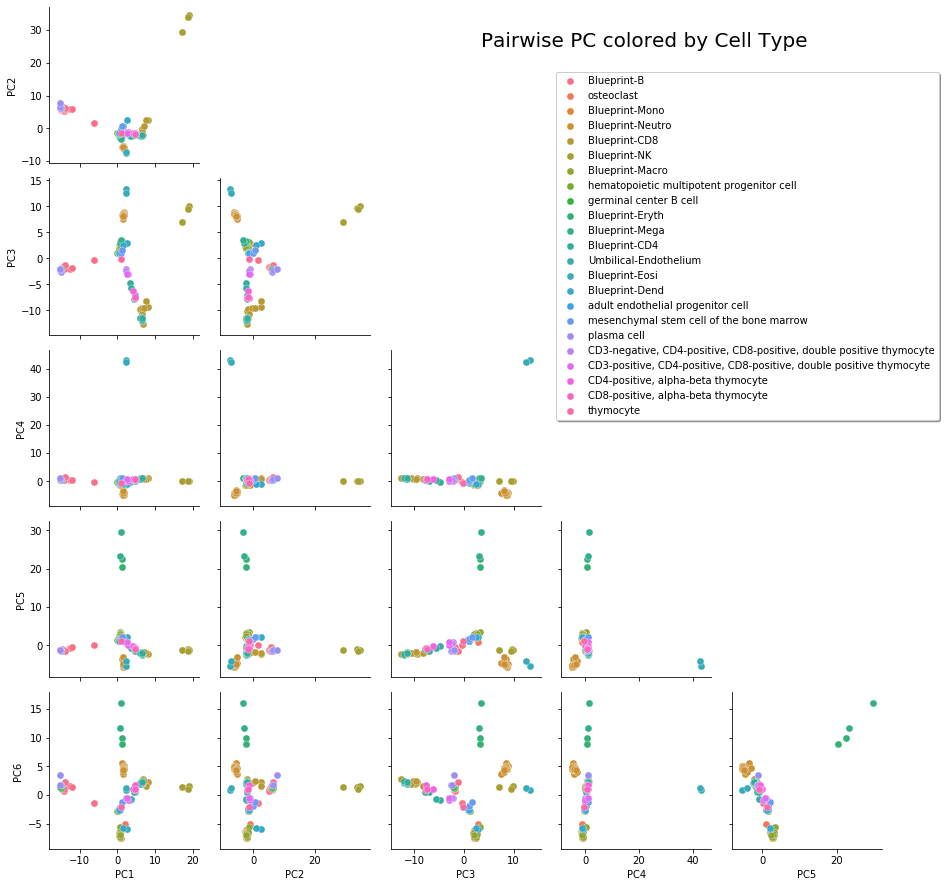

In [11]:
g = sns.PairGrid(pca_df, hue='sample_group')
g.map_lower(plt.scatter, s=50, edgecolor='white', linewidth=.3)
g.fig.suptitle("Pairwise PC colored by Cell Type", size=20, x=0.6, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 5), ncol=1, fancybox=True, shadow=True)
plt.show()

## PCs colored by age

In [12]:
# all age range
metadata.age.unique()

array(['0 - 5', '65 - 70', '80 - 85', '70 - 75', '20 - 30', '40 - 45',
       '35 - 40', '50 - 55', '60 - 65', '55 - 60', '20 - 40', '45 - 50',
       '30 - 35', '25 - 30', '5 - 10'], dtype=object)

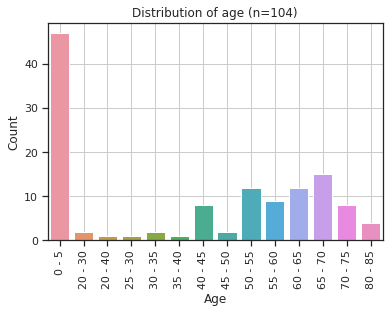

In [13]:
# barplot of age
counts = pca_df.age.value_counts()
age_order = ['0 - 5', '20 - 30', '20 - 40', '25 - 30', 
             '30 - 35', '35 - 40', '40 - 45', '45 - 50', 
             '50 - 55', '55 - 60', '60 - 65', '65 - 70', 
             '70 - 75', '80 - 85']
counts = counts.loc[age_order]


sns.set(style="ticks")
sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution of age (n=104)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid()
plt.show()

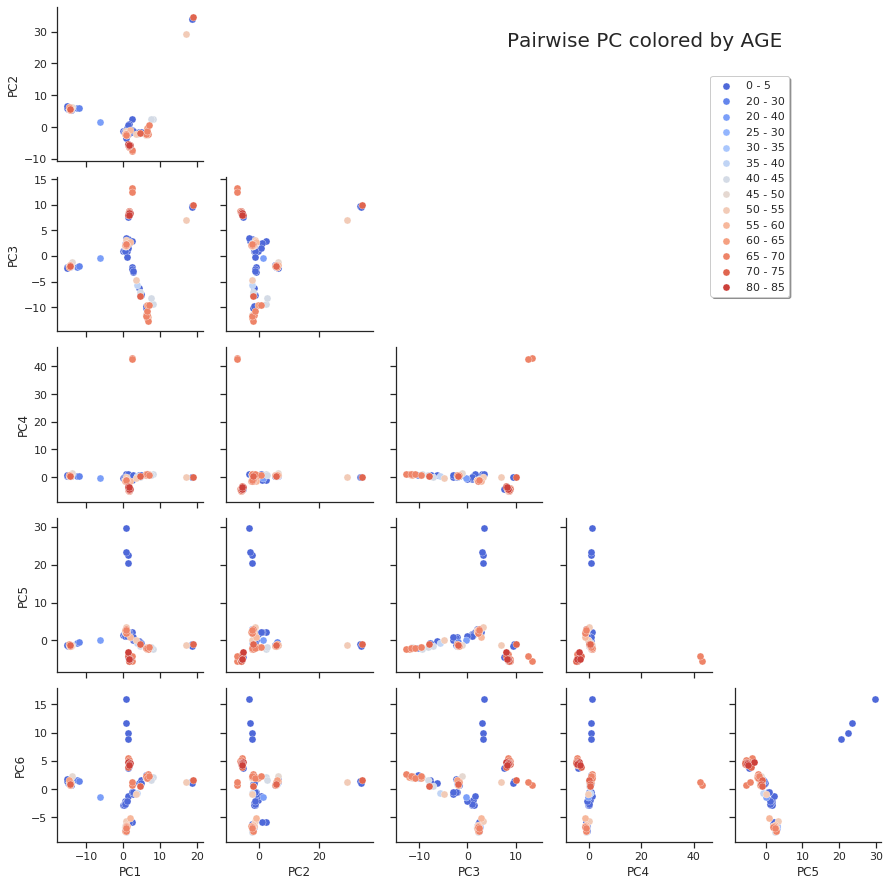

In [14]:
g = sns.PairGrid(pca_df, hue='age', palette='coolwarm', hue_order=age_order)
g.map_lower(plt.scatter, s=50, edgecolor='white', linewidth=.3)
g.fig.suptitle("Pairwise PC colored by AGE", size=20, x=0.6, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)

# plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, fancybox=True, shadow=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.1, 5), ncol=1, fancybox=True, shadow=True)
plt.show()

## PCs colored by sex

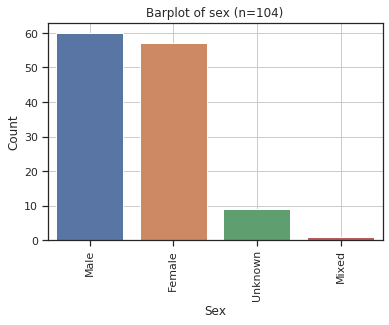

In [15]:
# barplot of age
counts = pca_df.sex.value_counts()

sns.set(style="ticks")
sns.barplot(x=counts.index, y=counts.values)
plt.title('Barplot of sex (n=104)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid()
plt.show()

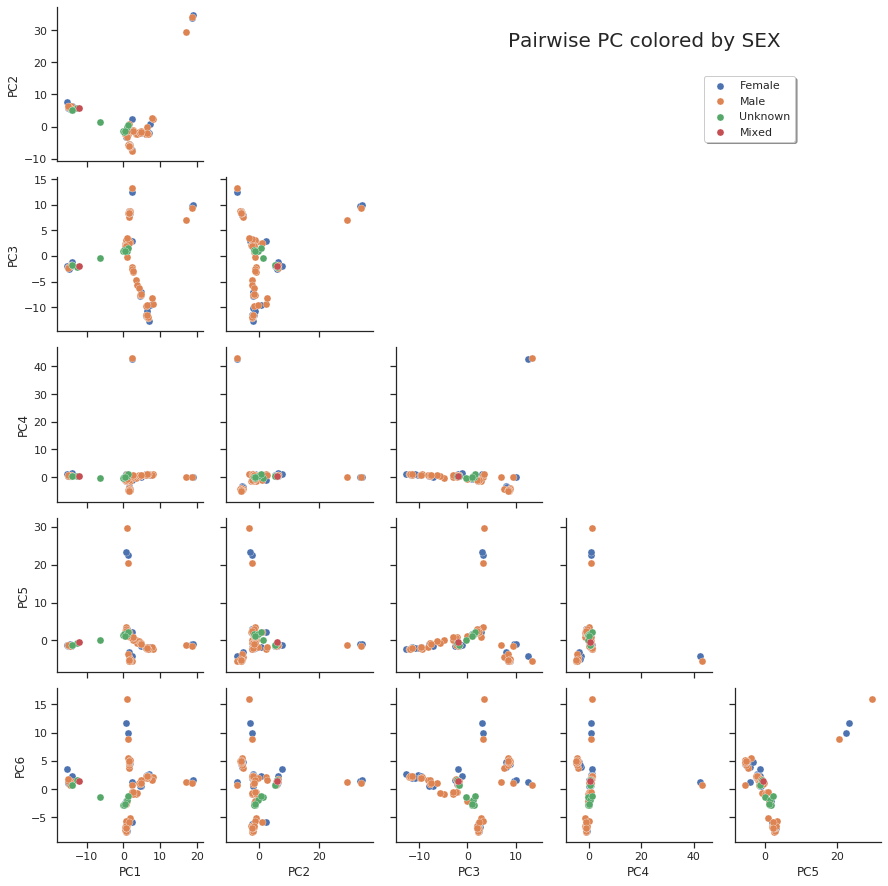

In [16]:
g = sns.PairGrid(pca_df, hue='sex')
g.map_lower(plt.scatter, s=50, edgecolor='white', linewidth=.3)
g.fig.suptitle("Pairwise PC colored by SEX", size=20, x=0.6, y=0.8)

# Remove axes of the upper triangle and the diagonal
for i, j in zip(*np.triu_indices_from(g.axes, k=0)):
    g.axes[i, j].set_visible(False)

# plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, fancybox=True, shadow=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.1, 5), ncol=1, fancybox=True, shadow=True)
plt.show()

### Reference region hypo-methylation distribution

In [17]:
data.region_id

0             Immune_Broad_Neutro-chr1:9147789-9147871
1             Immune_Broad_Neutro-chr1:9147789-9147871
2             Immune_Broad_Neutro-chr1:9147789-9147871
3             Immune_Broad_Neutro-chr1:9147789-9147871
4             Immune_Broad_Neutro-chr1:9147789-9147871
                              ...                     
204012    Immune_Refined_Eryth-chr22:44365225-44365375
204013    Immune_Refined_Eryth-chr22:44365225-44365375
204014    Immune_Refined_Eryth-chr22:44365225-44365375
204015    Immune_Refined_Eryth-chr22:44365225-44365375
204016    Immune_Refined_Eryth-chr22:44365225-44365375
Name: region_id, Length: 35154, dtype: object

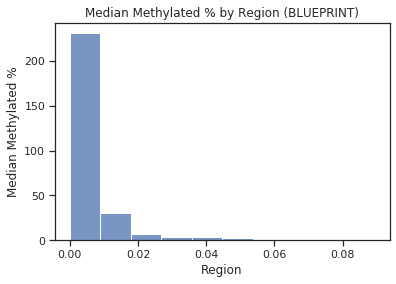

In [18]:
grouped = data.groupby('region_id')['frac_alpha_leq_25pct'] \
            .median() \
            .sort_values(ascending=False) \
            .reset_index()

sns.histplot(data=grouped, x='frac_alpha_leq_25pct')
plt.title('Median Methylated % by Region (BLUEPRINT)')
plt.xlabel('Region')
plt.ylabel('Median Methylated %')
plt.show()

In [19]:
sum(data['frac_alpha_leq_25pct'] > 0)

13072

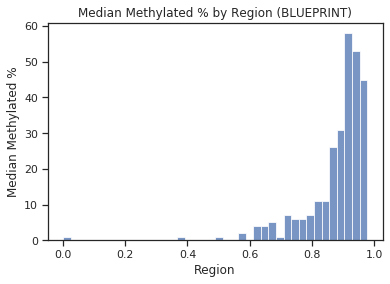

In [20]:
grouped = data.groupby('region_id')['frac_alpha_geq_75pct'] \
            .median() \
            .sort_values(ascending=False) \
            .reset_index()

sns.histplot(data=grouped, x='frac_alpha_geq_75pct')
plt.title('Median Methylated % by Region (BLUEPRINT)')
plt.xlabel('Region')
plt.ylabel('Median Methylated %')
plt.show()

In [21]:
sum(data['frac_alpha_geq_75pct'] > 0)

33488